In [1]:
"""
    Henter og strukturerer originale laksedata fra SSB via API (tabell 03024).
    Denne funksjonen er utgangspunktet for videre analyser og visualiseringer i prosjektet.
    Dataen visualiseres for å kunne analysere videre.
    Dataene inkluderer pris og vekt for fersk og frossen laks per uke over flere år.
"""

import requests
import pandas as pd
from itertools import product

# URL til SSB API for tabell 03024
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")

def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]

    # Kombinasjoner av dimensjoner
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    # Lag DataFrame og knytt til verdiene
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values

    # Pivotér data
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]

    # Del opp "Tid" i År og Uke
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)
    df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)
   


    # Fjern "Tid" og omorganiser kolonner slik at År og Uke kommer først
    df_pivot = df_pivot.drop(columns=["Tid"])
    kolonnerekkefølge = ["År", "Uke"] + [col for col in df_pivot.columns if col not in ["År", "Uke"]]
    df_pivot = df_pivot[kolonnerekkefølge]

    # Lag en uke-dato-kolonne for plotting (mandag i hver uke)
    df_pivot["UkeDato"] = pd.to_datetime(df_pivot["År"].astype(str) + "-" + df_pivot["Uke"].astype(str).str.zfill(2) + "-1", format="%Y-%W-%w")


    return df_pivot



def main(): #henter main og behandler dataen og returnerer df_pivot
    try:
        data = fetch_data()
        df_pivot = process_data(data)
        return df_pivot  # returnerer dataene fra main()
    except Exception as e:
        print(e)
        return None

if __name__ == "__main__":
    df_pivot = main()  # mottar resultatet fra main()
    if df_pivot is not None:
        print(df_pivot.to_string(index=False))  # dataene printes her 



  År  Uke  Fersk laks - Kilospris  Fersk laks - Vekt (tonn)  Frosset laks - Kilospris  Frosset laks - Vekt (tonn)    UkeDato
2000    1                   30.98                    3728.0                     32.54                       383.0 2000-01-03
2000    2                   31.12                    4054.0                     33.63                       216.0 2000-01-10
2000    3                   31.03                    4043.0                     36.06                       633.0 2000-01-17
2000    4                   30.95                    3730.0                     34.27                       393.0 2000-01-24
2000    5                   31.30                    3831.0                     33.91                       453.0 2000-01-31
2000    6                   32.53                    4415.0                     35.30                       265.0 2000-02-07
2000    7                   32.46                    4617.0                     34.49                       344.0 2000-02-14


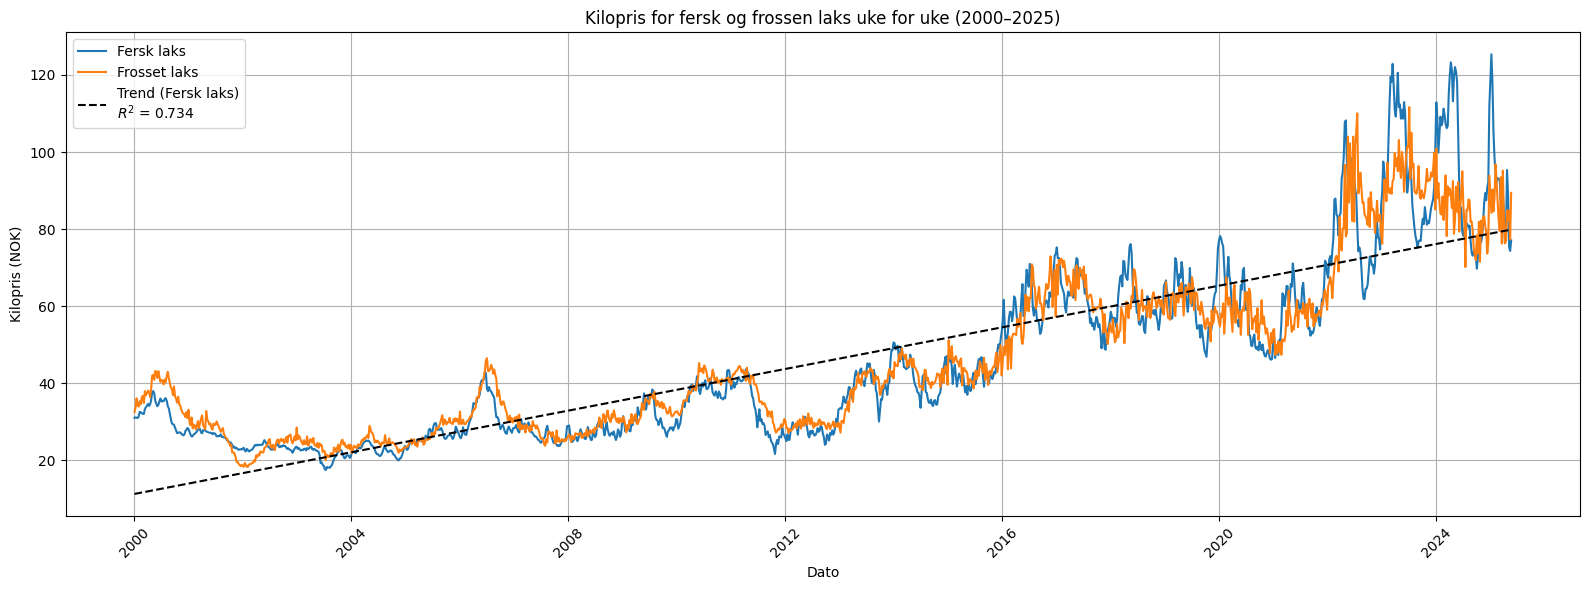

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import numpy as np

df = main()
if df is not None:
    # Konverter dato til numerisk format for regresjon
    df = df.dropna(subset=["Fersk laks - Kilospris"])  # Fjern NaN før analyse
    df = df.sort_values("UkeDato")
    df["DatoNum"] = df["UkeDato"].map(pd.Timestamp.toordinal)  # Gjør dato til tall

    X = df["DatoNum"].values.reshape(-1, 1)
    y = df["Fersk laks - Kilospris"].values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Plot originalt datasett
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=df, x="UkeDato", y="Fersk laks - Kilospris", label="Fersk laks")
    sns.lineplot(data=df, x="UkeDato", y="Frosset laks - Kilospris", label="Frosset laks")

    # Legg til regresjonslinje
    plt.plot(df["UkeDato"], y_pred, color="black", linestyle="--", label=f"Trend (Fersk laks)\n$R^2$ = {r2:.3f}")

    plt.title("Kilopris for fersk og frossen laks uke for uke (2000–2025)")
    plt.xlabel("Dato")
    plt.ylabel("Kilopris (NOK)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


Vi har lagt til en regresjonslinje med tilhørende R²-verdi for å vurdere sammenhengen mellom uke og kilopris. En høy R²-verdi indikerer at modellen forklarer store deler av variasjonen i prisene. Den skal vise hvor godt verdiene passer til en linær modell. Tallet er på 0.734 som er nærmere 1 enn 0 og det betyr at modellen passer dataene bra. Dette styrker troverdigheten til den visuelle analysen, og viser at det er en økning i prisene over tid.